In [1]:
!apt-get update && apt-get install -y libgl1
!pip install opencv-python-headless
!pip install numpy pandas matplotlib decord scipy pillow
!pip install moviepy==1.0.3
!pip install seaborn

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease   
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [4741 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [4587 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [55.7 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3350 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1561 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [47.7 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1254 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports/universe amd64 Packages [35.2 kB]
Get:13 http

In [2]:
import os
import warnings
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from decord import VideoReader
from moviepy.editor import AudioFileClip
from scipy.fftpack import dct
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Suppress warnings
warnings.simplefilter(action="ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Configure TensorFlow for GPU usage
device_name = tf.config.list_physical_devices('GPU')
if device_name:
    tf.config.optimizer.set_jit(True)
    keras.mixed_precision.set_global_policy("mixed_float16")
    for pd in device_name:
        tf.config.experimental.set_memory_growth(pd, True)
    strategy = tf.distribute.MirroredStrategy()
else:
    strategy = tf.distribute.get_strategy()  # Default strategy if no GPU is found

input_size = 224
num_frame = 16
batch_size = 4 * strategy.num_replicas_in_sync  # Declare batch size

# Setup complete, now ready to process video data
train_uc_set = '/home/jovyan/onmixed-data-last/MAFW_FSLF_split/train'
val_uc_set = '/home/jovyan/onmixed-data-last/MAFW_FSLF_split/val'
test_uc_set = '/home/jovyan/onmixed-data-last/MAFW_FSLF_split/test'

# Define the emotion labels from the file names
uc_label2id = {'anger': 0, 'disgust': 1, 'fear': 2, 'happiness': 3, 'sadness': 4}
uc_id2label = {v: k for k, v in uc_label2id.items()}


def is_video_valid(file_path):
    """Check if a video file is valid and can be read"""
    try:
        vr = VideoReader(file_path)
        if len(vr) > 0:
            return True
        return False
    except:
        return False


import pandas as pd

# Update the create_uc_dataframe function to handle the new directory structure
def create_uc_dataframe(path):
    data = []
    for emotion_name in os.listdir(path):
        emotion_dir = os.path.join(path, emotion_name)
        if os.path.isdir(emotion_dir) and emotion_name in uc_label2id:
            for video_file in os.listdir(emotion_dir):
                if video_file.endswith('.mp4'):
                    video_path = os.path.join(emotion_dir, video_file)
                    if is_video_valid(video_path):  # Check if video is usable
                        data.append({
                            'video_path': os.path.abspath(video_path),
                            'label': uc_label2id[emotion_name],
                            'class_name': emotion_name
                        })
                    else:
                        print(f"Skipping invalid video: {video_path}")
    df = pd.DataFrame(data)
    df = df.sample(frac=1).reset_index(drop=True)
    return df

train_uc_df = create_uc_dataframe(train_uc_set)
val_uc_df = create_uc_dataframe(val_uc_set)
test_uc_df = create_uc_dataframe(test_uc_set)

def read_video(file_path):
    try:
        file_path = file_path.numpy().decode('utf-8')
        vr = VideoReader(file_path)
        total_frames = len(vr)
        
        # Select frames evenly spaced throughout the video
        frame_indices = np.linspace(0, total_frames-1, num_frame, dtype=np.int32)
        
        # Ensure we don't request frames beyond video length
        frame_indices = np.clip(frame_indices, 0, total_frames-1)
        
        frames = vr.get_batch(frame_indices).asnumpy()
        return format_frames(frames, output_size=(input_size, input_size))
    except Exception as e:
        print(f"Error processing video {file_path}: {str(e)}")
        # Return blank frames if video can't be read
        return np.zeros((num_frame, input_size, input_size, 3), dtype=np.float32)

def format_frames(frames, output_size):
    frames = tf.image.convert_image_dtype(frames, tf.float32)
    frames = tf.image.resize(frames, size=list(output_size))
    return frames

def load_video(file_path, label):
    video = tf.py_function(func=read_video, inp=[file_path], Tout=tf.float32)
    video.set_shape([num_frame, input_size, input_size, 3])
    return video, tf.cast(label, dtype=tf.float32)

def create_dataloader(df, batch_size, shuffle=True, drop_reminder=True):
    # Filter out any remaining invalid paths just in case
    valid_paths = []
    valid_labels = []
    for path, label in zip(df['video_path'].values, df['label'].values):
        if os.path.exists(path):
            valid_paths.append(path)
            valid_labels.append(label)
    
    ds = tf.data.Dataset.from_tensor_slices((valid_paths, valid_labels))
    ds = ds.shuffle(8 * batch_size) if shuffle else ds
    ds = ds.map(load_video, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size, drop_remainder=drop_reminder)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_uc_ds = create_dataloader(train_uc_df, batch_size, shuffle=True)
val_uc_ds = create_dataloader(val_uc_df, batch_size, shuffle=False)
test_uc_ds = create_dataloader(test_uc_df, batch_size, shuffle=False)

# Load the pre-trained model
model_path = "/home/jovyan/onmixed-data-last/model"
pretrained_model = tf.saved_model.load(model_path)

class TFSMLayer(tf.keras.layers.Layer):
    def __init__(self, model):
        super(TFSMLayer, self).__init__()
        self.model = model

    def call(self, inputs):
        inputs = tf.cast(inputs, tf.float32)
        return self.model.signatures['serving_default'](input_1=inputs)['output_1']

# Define the model within the strategy scope
with strategy.scope():
    # Define the downstream model
    inputs = layers.Input(shape=(num_frame, input_size, input_size, 3))
    x = TFSMLayer(pretrained_model)(inputs)
    
    # Add some regularization
    #x = layers.Dropout(0.5)(x)
    
    # Define the output layer
    outputs = layers.Dense(len(uc_label2id), dtype='float32', activation=None)(x)

    # Create the model
    model = keras.Model(inputs=inputs, outputs=outputs, name="linear_probe_model")

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.AdamW(
            learning_rate=1e-3,
            weight_decay=0.05
        ),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseTopKCategoricalAccuracy(k=1, name="acc")
        ]
    )

model.summary()

history = model.fit(
        train_uc_ds,
        validation_data=val_uc_ds,
        steps_per_epoch=len(train_uc_df) // batch_size,
        validation_steps=len(val_uc_df) // batch_size,
        epochs=50,
        verbose=1
)

2025-06-29 11:52:50.701819: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA A100-SXM4-40GB MIG 2g.10gb, compute capability 8.0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


2025-06-29 11:52:53.146310: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7898 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 2g.10gb, pci bus id: 0000:90:00.0, compute capability: 8.0


Skipping invalid video: /home/jovyan/onmixed-data-last/MAFW_FSLF_split/train/happiness/happiness_01629.mp4
Skipping invalid video: /home/jovyan/onmixed-data-last/MAFW_FSLF_split/train/sadness/sadness_02839.mp4
Skipping invalid video: /home/jovyan/onmixed-data-last/MAFW_FSLF_split/train/sadness/sadness_03045.mp4
Skipping invalid video: /home/jovyan/onmixed-data-last/MAFW_FSLF_split/train/disgust/disgust_10135.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x563a258a1fc0] moov atom not found
[11:52:55] /github/workspace/src/video/video_reader.cc:83: ERROR opening: /home/jovyan/onmixed-data-last/MAFW_FSLF_split/train/disgust/disgust_08776.mp4, Invalid data found when processing input


Skipping invalid video: /home/jovyan/onmixed-data-last/MAFW_FSLF_split/train/disgust/disgust_08776.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x563a258a1fc0] moov atom not found
[11:52:55] /github/workspace/src/video/video_reader.cc:83: ERROR opening: /home/jovyan/onmixed-data-last/MAFW_FSLF_split/train/disgust/disgust_10160.mp4, Invalid data found when processing input


Skipping invalid video: /home/jovyan/onmixed-data-last/MAFW_FSLF_split/train/disgust/disgust_10160.mp4
Skipping invalid video: /home/jovyan/onmixed-data-last/MAFW_FSLF_split/train/fear/fear_10575.mp4


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x563a258a1fc0] moov atom not found
[11:52:56] /github/workspace/src/video/video_reader.cc:83: ERROR opening: /home/jovyan/onmixed-data-last/MAFW_FSLF_split/val/anger/anger_03810.mp4, Invalid data found when processing input


Skipping invalid video: /home/jovyan/onmixed-data-last/MAFW_FSLF_split/val/anger/anger_03810.mp4
Skipping invalid video: /home/jovyan/onmixed-data-last/MAFW_FSLF_split/test/sadness/sadness_01788.mp4
Skipping invalid video: /home/jovyan/onmixed-data-last/MAFW_FSLF_split/test/fear/fear_03567.mp4
Skipping invalid video: /home/jovyan/onmixed-data-last/MAFW_FSLF_split/test/fear/fear_01471.mp4
Model: "linear_probe_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 224, 224, 3   0         
                             )]                                  
                                                                 
 tfsm_layer (TFSMLayer)      (None, 400)               0         
                                                                 
 dense (Dense)               (None, 5)                 2005      
                                                     

2025-06-29 11:53:13.572869: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 928
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
      

Epoch 1/50
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tens

2025-06-29 11:53:23.730319: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x563a86b64a80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-06-29 11:53:23.730375: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB MIG 2g.10gb, Compute Capability 8.0
2025-06-29 11:53:24.646487: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-29 11:53:26.542632: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2025-06-29 11:53:31.383268: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


232/232 [==============================] - ETA: 0s - loss: 1.6913 - acc: 0.2478INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


2025-06-29 11:55:22.837213: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:786] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_2"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_STRING
      type: DT_INT32
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 199
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:5"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
      }
      shape {
      }
    }
  }
}
attr {
  key: "replicate_on_split"
  value {
    b: false
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PRODUCT
      args {
        type_id: TFT_TENSOR
        args {
      

232/232 [==============================] - 161s 616ms/step - loss: 1.6913 - acc: 0.2478 - val_loss: 1.5702 - val_acc: 0.3163
Epoch 2/50
232/232 [==============================] - 139s 597ms/step - loss: 1.4083 - acc: 0.3998 - val_loss: 1.4574 - val_acc: 0.3980
Epoch 3/50
232/232 [==============================] - 138s 590ms/step - loss: 1.3104 - acc: 0.4537 - val_loss: 1.4163 - val_acc: 0.3929
Epoch 4/50
232/232 [==============================] - 138s 591ms/step - loss: 1.2437 - acc: 0.5000 - val_loss: 1.4084 - val_acc: 0.4082
Epoch 5/50
232/232 [==============================] - 137s 586ms/step - loss: 1.1925 - acc: 0.5237 - val_loss: 1.3844 - val_acc: 0.4235
Epoch 6/50
232/232 [==============================] - 137s 588ms/step - loss: 1.1587 - acc: 0.5334 - val_loss: 1.3779 - val_acc: 0.4286
Epoch 7/50
232/232 [==============================] - 136s 586ms/step - loss: 1.1338 - acc: 0.5485 - val_loss: 1.3638 - val_acc: 0.4745
Epoch 8/50
232/232 [==============================] - 137s 

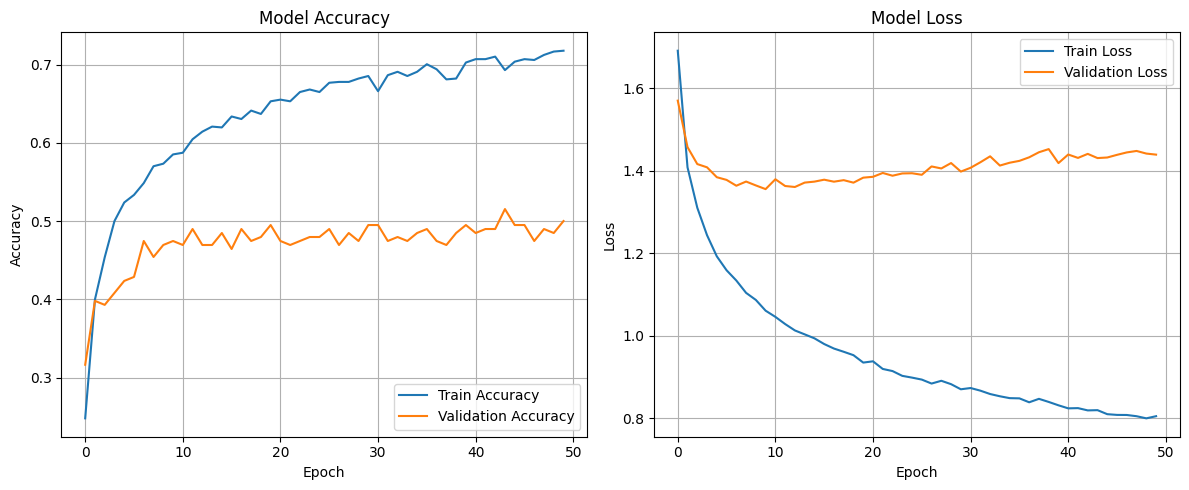


Train Set Evaluation

Classification Report:
              precision    recall  f1-score   support

       anger     0.7594    0.7594    0.7594       187
     disgust     0.6837    0.7946    0.7350       185
        fear     0.8032    0.8118    0.8075       186
   happiness     0.7472    0.7151    0.7308       186
     sadness     0.7312    0.6359    0.6802       184

    accuracy                         0.7435       928
   macro avg     0.7449    0.7433    0.7426       928
weighted avg     0.7451    0.7435    0.7427       928



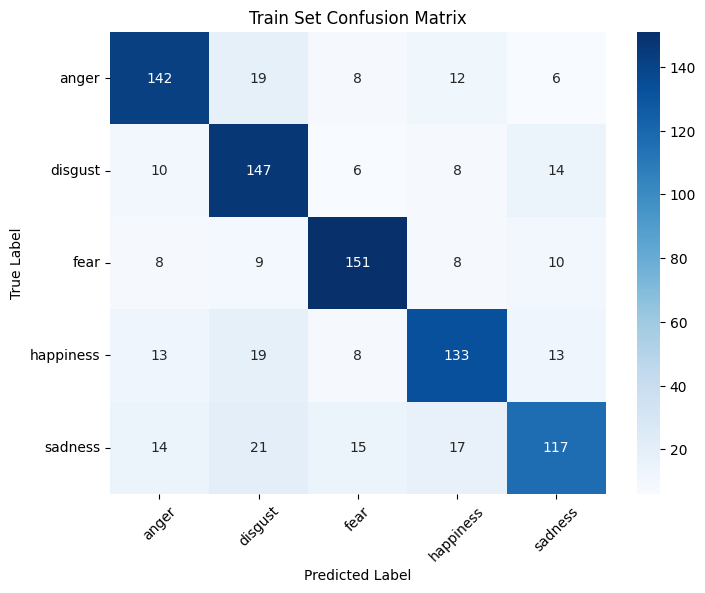

Train Accuracy: 0.7435
Total Train Samples Evaluated: 928

Validation Set Evaluation

Classification Report:
              precision    recall  f1-score   support

       anger     0.4773    0.5385    0.5060        39
     disgust     0.3947    0.3947    0.3947        38
        fear     0.6364    0.5250    0.5753        40
   happiness     0.5116    0.5500    0.5301        40
     sadness     0.5000    0.4872    0.4935        39

    accuracy                         0.5000       196
   macro avg     0.5040    0.4991    0.4999       196
weighted avg     0.5053    0.5000    0.5010       196



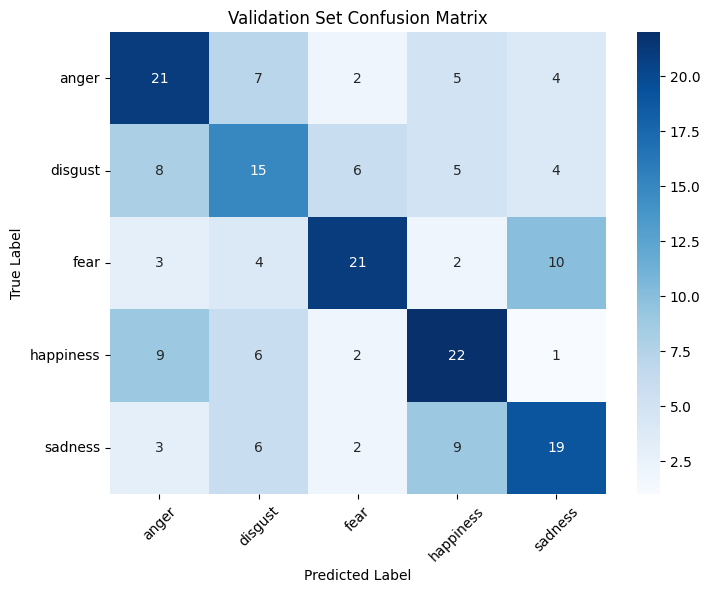

Validation Accuracy: 0.5000
Total Validation Samples Evaluated: 196

Test Set Evaluation

Classification Report:
              precision    recall  f1-score   support

       anger     0.3171    0.3333    0.3250        39
     disgust     0.4857    0.4146    0.4474        41
        fear     0.5610    0.5897    0.5750        39
   happiness     0.4146    0.4146    0.4146        41
     sadness     0.4524    0.4750    0.4634        40

    accuracy                         0.4450       200
   macro avg     0.4462    0.4455    0.4451       200
weighted avg     0.4463    0.4450    0.4449       200



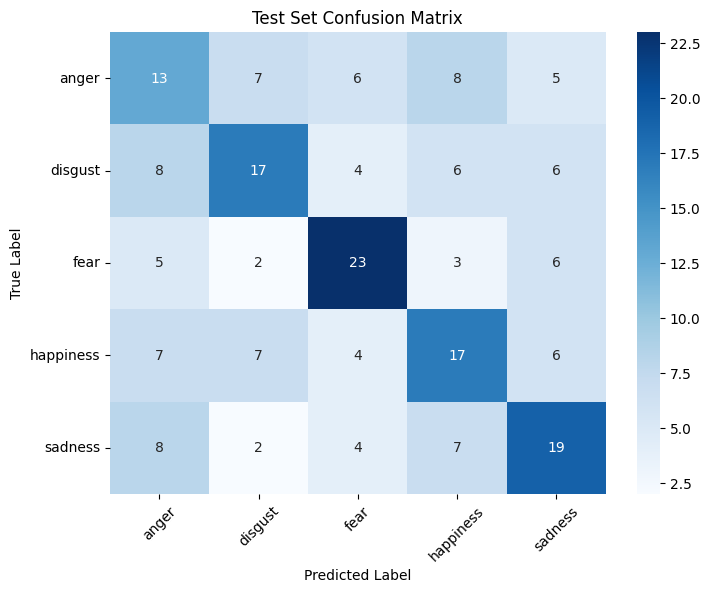

Test Accuracy: 0.4450
Total Test Samples Evaluated: 200


In [3]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_model(model, train_ds, val_ds, test_ds, label_mapping):
    """
    Evaluate model performance and generate visualizations
    Args:
        model: Trained Keras model
        train_ds: Training dataset
        val_ds: Validation dataset
        test_ds: Test dataset
        label_mapping: Dictionary mapping class indices to names
    """
    # Plot training history
    plt.figure(figsize=(12, 5))
    
    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['acc'], label='Train Accuracy')
    plt.plot(history.history['val_acc'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')
    plt.grid(True)
    
    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

    def safe_predict(dataset):
        """Handle potential video reading errors during prediction"""
        y_true = []
        y_pred = []
        error_count = 0
        
        for videos, labels in dataset:
            try:
                preds = model.predict(videos, verbose=0)
                y_pred.extend(np.argmax(preds, axis=1))
                y_true.extend(labels.numpy())
            except Exception as e:
                error_count += 1
                continue
        
        if error_count > 0:
            print(f"Warning: Skipped {error_count} batches due to errors")
        return y_true, y_pred

    # Evaluate on all datasets
    for ds_name, dataset in [('Train', train_ds), ('Validation', val_ds), ('Test', test_ds)]:
        print(f"\n{'='*40}")
        print(f"{ds_name} Set Evaluation")
        print(f"{'='*40}")
        
        y_true, y_pred = safe_predict(dataset)
        
        if not y_true:
            print(f"No valid predictions for {ds_name} set")
            continue
            
        # Generate classification report
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, 
                                  target_names=list(label_mapping.keys()),
                                  digits=4))
        
        # Generate confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=list(label_mapping.keys()),
                    yticklabels=list(label_mapping.keys()))
        plt.title(f'{ds_name} Set Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.show()
        
        # Calculate and display accuracy
        accuracy = np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)
        print(f"{ds_name} Accuracy: {accuracy:.4f}")
        print(f"Total {ds_name} Samples Evaluated: {len(y_true)}")

# Run evaluation
evaluate_model(model, train_uc_ds, val_uc_ds, test_uc_ds, uc_label2id)